In [ ]:
#이미지가 70000개

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
#X는 이미지 데이터 특성 28*28=784 (컬럼) 각 특성은 0~255의 픽셀강도를 나타냄 
#Y는 이미지 데이터의 정수 값 (답)

In [5]:
X,y =mnist["data"], mnist["target"]
X.shape , y.shape

((70000, 784), (70000,))

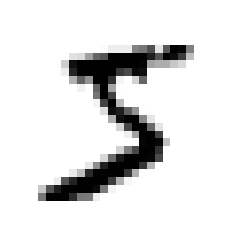

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [8]:
y[0]

'5'

In [9]:
y=y.astype(np.uint8)

In [10]:
#훈련데이터 테스트 데이터 나누기
X_train, X_test, y_train, y_test = X[:6000], X[6000:], y[:6000], y[6000:]

1. 이진 분류기 훈련
문제를 단순화해서 하나의 숫자를 분류해보기

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

1. - 1 확률적 경사 하강법 - SGDClassifier 
SGD는 한번에 하나의 훈련 샘플을 독립적으로 처리/큰 데이터셋을 효율적으로 처리

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit]) #some_digit=5

array([ True])

성능측정 cross_val_score() - 3겹인 k-fold 교차검증

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for  train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.962
0.956
0.9665


In [23]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.962 , 0.956 , 0.9665])

5가 아닌 값을 예측하는 더미변수 데이터 만들기

In [28]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self, x):
        return np.zeros((len(x),1),dtype=bool)
    
never_5_clf = Never5Classifier()    

In [34]:
from sklearn.model_selection import cross_val_score
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91 , 0.915, 0.918])

In [ ]:
#5가 아닌 데이터가 90%가 넘음으로 아니라고 했을 경우 정확도는 90% 이상 정확도는 불균형한 데이터 셋을 다룰 경우 의미 없음

2. 오차행렬 - 잘못 분류한 횟수를 알고 싶을 때

In [38]:
#실제 타깃과 비교할 수 있는 예측값 만들기
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict() 함수는 k-fold 교차검증을 수행하나 평가점수가 아닌 각 테스트 폴드의 얻은 예측을 반환 

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[5375,  111],
       [ 120,  394]])

오차행렬의 행은 실제 값 클래스, 열은 예측 클래스 [true_value vs true_prediction , true_value vs false_prediction],[false_value vs true_prediction,false_value vs false_prediction ]

In [43]:
#완벽 분류인경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[5486,    0],
       [   0,  514]])

In [ ]:
정밀도(precision) tp/tp+fp 예측한 것중 진짜가 얼마나 차지하는지 따라서 모델이 정확한 값을 예측을 못한다면 의미없음
재현율(recall) tp/tp+fn 모델이 정확하게 감지한 샘플의 비율 fn+tp 는 전제 찾으려는 데이터 그중에 정말로 찾은 tp값

In [ ]:
2 -1 정밀도 재현율, f-score

In [45]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.7801980198019802, 0.7665369649805448)

f-score는 recall 과 precision의 조화평균
f1=2/(1/recall+1/precision), tp/tp+(fn+fp)/2

In [46]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7733071638861628

2 -2 정밀도 / 재현율 trade off
정밀도와 재현율은 반비례 관계 
결정함수를 사용해 각 샘플의 점수를 계산, 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당, 아니면 음성클래스에 할당

In [69]:
y_scores = sgd_clf.decision_function([X[0]])
y_scores

array([38042.34312442])

In [70]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [87]:
threshold = 20000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False, ..., False, False, False])

In [88]:
#적절한 임계값 찾기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [89]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

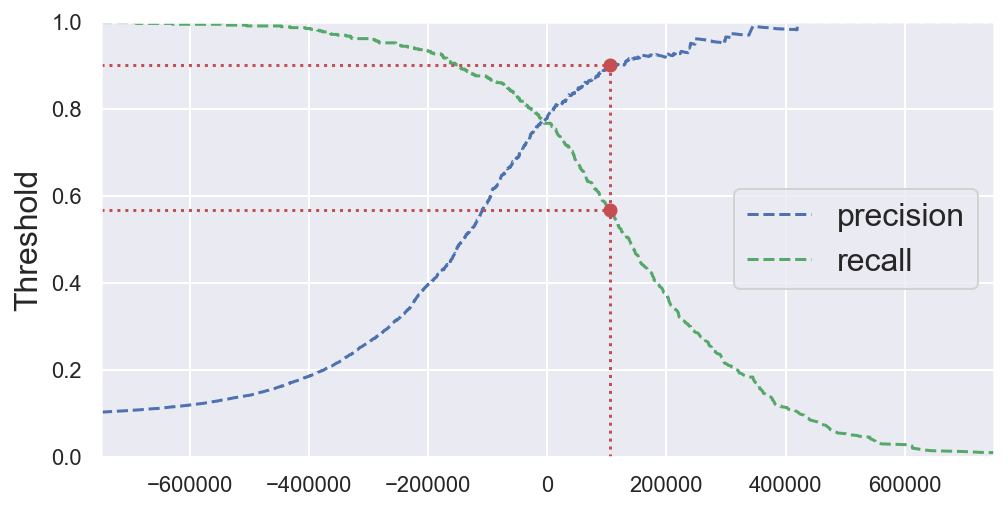

In [136]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.legend(loc="center right", fontsize=16)
    plt.ylabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-750000,750000,0,1])

recall_90 = recalls[np.argmax(precisions >=0.9)]
threshold_90 = thresholds[np.argmax(precisions >=0.9)]
    
plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([threshold_90, threshold_90],[0,0.9],"r:")
plt.plot([-750000, threshold_90],[0.9,0.9],"r:" )
plt.plot([-750000, threshold_90],[recall_90, recall_90],"r:" )

plt.plot([threshold_90],[0.9],"ro" )
plt.plot([threshold_90],[recall_90],"ro" )

plt.show()

In [139]:
# precision 90이상이 목표면
threshold_90_precision = thresholds[np.argmax(precisions >=0.9)]

In [140]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [143]:
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9012345679012346, 0.5680933852140078)

In [ ]:
2 - 3 ROC 커브
